# Using Pretrained Networks - Codealong

## Introduction

In this lesson, you'll further practice the ideas behind CNN and adapting pretrained models as described in previous lessons. You'll once again work on the Santa or Not Santa problem scenario you've seen before!

## Objectives

You will be able to:

- Explain what "freezing" and "unfreezing" a layer means in a neural network 
- Implement feature engineering and fine tuning on a pre-trained model 
- Use Keras to adapt a pretrained CNN 

In [1]:
import datetime

start = datetime.datetime.now()

In [2]:
import os, shutil
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img

np.random.seed(123)

Using TensorFlow backend.


In [3]:
train_folder = 'split/train'
test_folder = 'split/test'
val_folder = 'split/validation'

In [4]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

## VGG19: Feature extraction

In [5]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

80142336/80134624 [==============================] - 9s 0us/step


In [6]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 2, 2, 512)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(64, 64), 
        batch_size = 10, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [8]:
# You should be able to divide sample_amount by batch_size
train_features, train_labels = extract_features(train_folder, 540) 
validation_features, validation_labels = extract_features(val_folder, 200) 
test_features, test_labels = extract_features(test_folder, 180)

train_features = np.reshape(train_features, (540, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (200, 2 * 2 * 512))
test_features = np.reshape(test_features, (180, 2 * 2 * 512))

Found 542 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=2*2*512))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Train on 540 samples, validate on 200 samples
Epoch 1/20
540/540 [==============================] - 0s 486us/step - loss: 0.4193 - acc: 0.8370 - val_loss: 0.2901 - val_acc: 0.9150
Epoch 2/20
540/540 [==============================] - 0s 368us/step - loss: 0.2361 - acc: 0.9185 - val_loss: 0.2000 - val_acc: 0.9300
Epoch 3/20
540/540 [==============================] - 0s 345us/step - loss: 0.1741 - acc: 0.9370 - val_loss: 0.1685 - val_acc: 0.9350
Epoch 4/20
540/540 [==============================] - 0s 347us/step - loss: 0.1371 - acc: 0.9611 - val_loss: 0.1587 - val_acc: 0.9400
Epoch 5/20
540/540 [==============================] - 0s 360us/step - loss: 0.1136 - acc: 0.9574 - val_loss: 0.1535 - val_acc: 0.9400
Epoch 6/20
540/540 [==============================] - 0s 345us/step - loss: 0.0964 - acc: 0.9704 - val_loss: 0.1449 - val_acc: 0.9450
Epoch 7/20
540/540 [==============================] - 0s 332us/step - loss: 0.0794 - acc: 0.9796 - val_loss: 0.1386 - val_acc: 0.9350
Epoch 8/20
540/5

In [10]:
results_test = model.evaluate(test_features, test_labels)
results_test

180/180 [==============================] - 0s 33us/step


[0.2355862256553438, 0.9333333373069763]

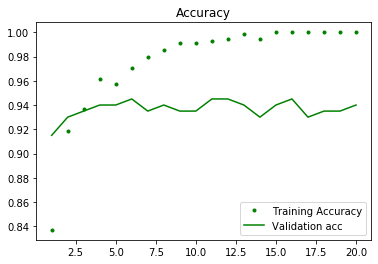

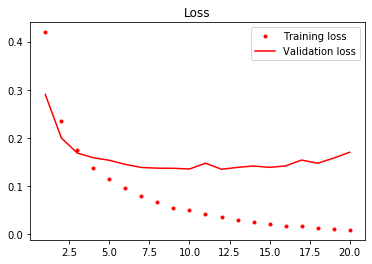

In [11]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

Using VGG-19 you're able to get test set performance up to almost 92%. Quite impressive!

In [12]:
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction method 1 took {} to execute.'.format(elapsed))
startp = datetime.datetime.now() # Set new start time for new process method

Feature extraction method 1 took 0:02:22.239808 to execute.


## Feature Extraction: Method 2

Here, you'll see another method for performing feature extraction which will segue naturally into methods for fine tuning a pretrained network. This method of feature extraction is more costly than the previous methodology but has some added benefits in that it will allow us to also perform our usual data augmentation techniques.  

Here's an overview of the process:
* Add the pretrained model as the first layer
* Add some dense layers for a classifier on top
* Freeze the convolutional base
* Train the model

The new part of this process which you have yet to see is freezing layers. This means that all of the weights associated with that layer(s) will remain unchanged through the optimization process. Freezing the base is important as you wish to preserve the features encoded in this CNN base. Without this, the volatile gradients will quickly erase the useful features of the pretrained model. 

In [13]:
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Freezing

Now that you've designed the model architecture, you'll freeze the base. With this, learning to check whether layers are frozen or not is a valuable skill.

In [14]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 True
flatten_1 True
dense_3 True
dense_4 True
36


Freezing a layer is very straightforward: set the `trainable` attribute to False.

In [15]:
cnn_base.trainable = False

A quick sanity check is also prudent and verifies that the base model is indeed frozen:

In [16]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 False
flatten_1 True
dense_3 True
dense_4 True
4


From there, training the model happens as usual.   

Define the training-validation-test sets (now with data augmentation; the advantage of this method of feature-extraction).

In [17]:
# Get all the data in the directory split/train (542 images), and reshape them
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_folder,  
                                                    target_size=(64, 64),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary') 

# Get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,  
                                                                       target_size=(64, 64),  
                                                                       batch_size=20, 
                                                                       class_mode='binary')

# Get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,  
                                                                        target_size=(64, 64), 
                                                                        batch_size=180,
                                                                        class_mode='binary')

test_images, test_labels = next(test_generator)

Found 542 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


Compile the model as usual:

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

And fit the model:

In [21]:
# ⏰ This cell may take several minutes to run
history = model.fit_generator(train_generator,
                              steps_per_epoch=27,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=10)

Epoch 1/10
27/27 [==============================] - 7s 264ms/step - loss: 0.3779 - acc: 0.8697 - val_loss: 0.2377 - val_acc: 0.9050
Epoch 2/10
27/27 [==============================] - 7s 259ms/step - loss: 0.3550 - acc: 0.8812 - val_loss: 0.3687 - val_acc: 0.9050
Epoch 3/10
27/27 [==============================] - 7s 245ms/step - loss: 0.3489 - acc: 0.8851 - val_loss: 0.2787 - val_acc: 0.9100
Epoch 4/10
27/27 [==============================] - 7s 242ms/step - loss: 0.3648 - acc: 0.8736 - val_loss: 0.3041 - val_acc: 0.9000
Epoch 5/10
27/27 [==============================] - 7s 244ms/step - loss: 0.3403 - acc: 0.8833 - val_loss: 0.2850 - val_acc: 0.9150
Epoch 6/10
27/27 [==============================] - 6s 233ms/step - loss: 0.3277 - acc: 0.8946 - val_loss: 0.3361 - val_acc: 0.9150
Epoch 7/10
27/27 [==============================] - 7s 263ms/step - loss: 0.3272 - acc: 0.8690 - val_loss: 0.2347 - val_acc: 0.9200
Epoch 8/10
27/27 [==============================] - 6s 239ms/step - loss: 0.

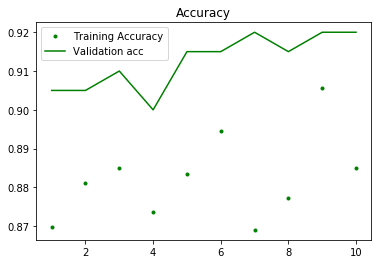

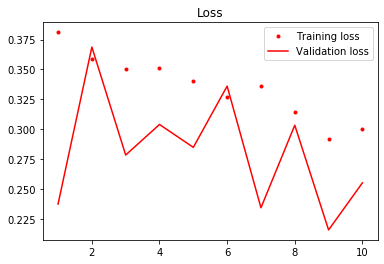

In [22]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

> Since both training and validation accuracy continue to fall in these graphs you would normally train for more epochs. To conserve time, this is not demonstrated, but whenever training AND VALIDATION accuracy continue to drop, then the model is probably underfit and can benefit from additional epochs.

In [23]:
end = datetime.datetime.now()
elapsed = end - startp
print('Feature extraction method 2 took {} to execute.'.format(elapsed))
elapsed = end - start
print('Total running time of notebook thus far: {}'.format(elapsed))
startp = datetime.datetime.now() # Set new start time for new process method

Feature extraction method 2 took 0:11:11.416370 to execute.
Total running time of notebook thus far: 0:13:33.656178


## Fine Tuning

Fine tuning starts with the same procedure as that for feature extraction. From there, you can further fine tune the weights of the most abstract layers of the convolutional base. 

When fine tuning these layers from the convolutional base, it is essential that you first freeze the entire convolutional base and train a classifier as we discussed with the feature engineering technique above. Without this, when gradient descent is initialized to optimize our loss function, you're apt to loose any significant patterns learned by the original classifier that you're adapting to the current situation. As a result, you must first tune the fully connected classifier that sits on top of the pretrained convolutional base. From there, the model should have a relatively strong accuracy and you can fine tune the weights of the last few layers of the convolutional base. Unfreezing initial layers of the convolutional base will typically not produce substantial gains as these early layers learn simple representations such as colors and edges which are useful in all forms of image recognition, regardless of application.   

With that, let's continue fine tuning the model.

**Warning: Fine tuning can be a resource intensive procedure.** 

Recall that model's architecture: 

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 132)               270468    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 133       
Total params: 20,294,985
Trainable params: 270,601
Non-trainable params: 20,024,384
_________________________________________________________________


And you can also further investigate the borrowed convolutional base:

In [25]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Important Reminders on Fine Tuning: Feature Extraction Must Come First!
Up to now, you have frozen the entire convolutional base. Again, it cannot be stressed enough how important this is before fine tuning the weights of the later layers of this base. Without training a classifier on the frozen base first, there will be too much noise in the model and initial epochs will overwrite any useful representations encoded in the pretrained model. That said, now that you have tuned a classifier to the frozen base, you can now unfreeze a few of the deeper layers from this base and further fine tune them to our problem scenario. In practice, this is apt to be particularly helpful where adapted models span new domain categories. For example, if the pretrained model is on cats and dogs and this is adapted to a problem specific to cats (a very relatively similar domain) there is apt to be little performance gain from fine tuning. On the other hand, if the problem domain is substantially different, additional gains are more likely in adjusting these more abstract layers of the convolutional base. With that, here's how to unfreeze and fine tune these later layers. 

First, unfreeze the base. 

In [26]:
cnn_base.trainable = True

Then, you can refreeze all layers up to a specific layer. Here you're unfreezing the final *block* of layers.  
(You will see diminishing returns if you continue to unfreeze additional layers.) 

In [27]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Finally, we must recompile our model before fitting.

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4), 
              metrics=['accuracy'])

Afterwards, we can then fit the model as usual.

In [29]:
# ⏰ This cell may take several minutes to run
history = model.fit_generator(train_generator,
                              steps_per_epoch=27,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=10)

Epoch 1/10
27/27 [==============================] - 10s 368ms/step - loss: 0.6093 - accuracy: 0.7739 - val_loss: 0.2645 - val_accuracy: 0.9200
Epoch 2/10
27/27 [==============================] - 10s 363ms/step - loss: 0.2812 - accuracy: 0.8927 - val_loss: 0.1315 - val_accuracy: 0.9300
Epoch 3/10
27/27 [==============================] - 10s 363ms/step - loss: 0.1922 - accuracy: 0.9330 - val_loss: 0.0853 - val_accuracy: 0.9450
Epoch 4/10
27/27 [==============================] - 10s 373ms/step - loss: 0.2019 - accuracy: 0.9222 - val_loss: 0.0917 - val_accuracy: 0.9400
Epoch 5/10
27/27 [==============================] - 9s 344ms/step - loss: 0.2262 - accuracy: 0.9306 - val_loss: 0.4338 - val_accuracy: 0.8750
Epoch 6/10
27/27 [==============================] - 9s 350ms/step - loss: 0.1616 - accuracy: 0.9406 - val_loss: 0.0251 - val_accuracy: 0.9450
Epoch 7/10
27/27 [==============================] - 10s 360ms/step - loss: 0.2732 - accuracy: 0.9406 - val_loss: 0.1602 - val_accuracy: 0.9400
E

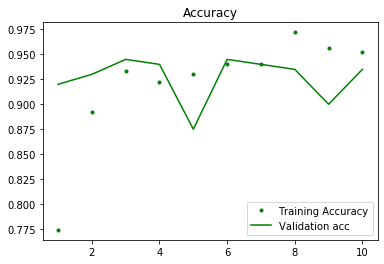

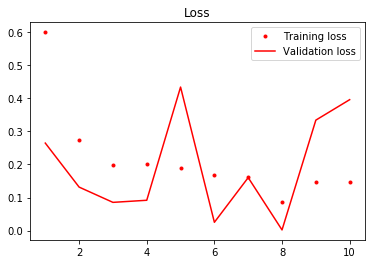

In [33]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

## Final Evaluation

As usual, conclude with a final evaluation on the test set.

In [34]:
# ⏰ This cell may take several minutes to run

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=20,
#                                                   class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.949999988079071


The model with fine-tuning seems to have similar results, but was much more costly to compute in terms of time. 

## Summary

In this lesson, you learned how to adapt a pretrained model to your own application. This can be a useful technique when data is limited (less then tens or hundreds of thousands of examples). To do this, you build a new classifier on top of the original convolutional base. Then, if the category or class of images is substantially different, fine tuning the most abstract layers of the convolutional base may further bolster performance. From here, it's time to fully synthesize all the image recognition techniques you have learned to date and practice with a real world example from a Kaggle competition.